<div style="text-align: center;">
    <h2>Modelado - XGBoost</h2>
</div>

## Índice

- [1 - Preparación de Datos](#preparaciondedatos)
- [1.1 - Instalación Librerias](#instalacionlibrerias)
- [1.2 - Carga de Datos](#cargadedatos)
- [2 - Transformación de Datos](#transformaciondedatos)
- [3 - Modelado - XGBoost](#xgboost)

### 1 - Preparación de Datos <a name="preparaciondedatos"></a>

#### 1.1 - Instalación Librerias <a name="instalacionlibrerias"></a>

In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


#### 1.2 - Importar Librerias <a name="importarlibrerias"></a>

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna
import warnings
import joblib

# Ignore all warnings
warnings.filterwarnings('ignore')


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [6]:
# Se define función que cuenta la cantidad de valores nulos en cada columna de un DataFrame y se calcula
# el porcentaje de valores nulos por columna.

def contar_valores_nulos_con_porcentaje(dataframe):

    nulos_por_columna = dataframe.isnull().sum()
    porcentaje_nulos_por_columna = (nulos_por_columna / len(dataframe)) * 100

    resultados = pd.DataFrame({
        'Cantidad de Nulos': nulos_por_columna,
        'Porcentaje de Nulos (%)': porcentaje_nulos_por_columna
    })

    return resultados

#Se define función que elimina los valores atípicos de una columna específica en un DataFrame.
#La misma utiliza el método de rango intercuartílico para identificar valores atípicos, que son aquellos puntos de datos
#que caen fuera del rango definido por el primer cuartil (Q1) y el tercer cuartil (Q3).

def remove_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    return df_filtered

#Se define función que elimina iterativamente los valores atípicos de una columna específica en un DataFrame hasta que
#no se encuentren más valores atípicos según el criterio del rango intercuartílico definido en la función "remove_outliers".

def remove_outliers_iteratively(df, column_name):
    df_clean = df.copy()
    while True:
        initial_len = len(df_clean)
        df_clean = remove_outliers(df_clean, column_name)
        final_len = len(df_clean)
        if initial_len == final_len:
            break
    return df_clean

In [7]:
def count_outliers(df, column):
    """
    Cuenta el número de valores atípicos en una columna específica de un DataFrame.

    Args:
    df (pandas.DataFrame): El DataFrame que contiene los datos.
    column (str): El nombre de la columna en la que se contarán los valores atípicos.

    Returns:
    int: El número de valores atípicos en la columna especificada.
    """
    # Calcular Q1 (primer cuartil), Q3 (tercer cuartil) y el IQR (rango intercuartílico)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Definir los límites para los valores atípicos
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar los valores atípicos
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = outliers.shape[0]

    return num_outliers

#### 1.3 - Carga de Datos <a name="cargadedatos"></a>

In [8]:
train_df = pd.read_csv('train.csv')  
test_df = pd.read_csv('test.csv')  
sample_submission = pd.read_csv('sample_submission.csv')

In [9]:
train_df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [10]:
test_df.head(5)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


### 2 - Transformación de Datos <a name="transformaciondedatos"></a>

In [12]:
object_cols = train_df.select_dtypes(include=['object']).columns

label_encoders = {}

for col in object_cols:
    le = LabelEncoder()
    train_df[col + '_encoded'] = le.fit_transform(train_df[col].astype(str))
    label_encoders[col] = le  

In [13]:
object_cols = test_df.select_dtypes(include=['object']).columns

label_encoders = {}

for col in object_cols:
    le = LabelEncoder()

    test_df[col + '_encoded'] = le.fit_transform(test_df[col].astype(str))
    label_encoders[col] = le 

In [14]:
contar_valores_nulos_con_porcentaje(train_df)

,Cantidad de Nulos,Porcentaje de Nulos (%)
id,0,0.000000
brand,0,0.000000
model,0,0.000000
model_year,0,0.000000
milage,0,0.000000
fuel_type,5083,2.696080
engine,0,0.000000
transmission,0,0.000000
ext_col,0,0.000000
int_col,0,0.000000


In [15]:
train_df['clean_title'].value_counts()

clean_title
Yes    167114
Name: count, dtype: int64

In [16]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = train_df['clean_title'].value_counts().idxmax()

# Reemplazar los valores nulos (NaN) con el valor más frecuente
train_df['clean_title'] = train_df['clean_title'].fillna(most_frequent)


In [17]:
train_df['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [18]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = train_df['accident'].value_counts().idxmax()

# Reemplazar los valores nulos (NaN) con el valor más frecuente
train_df['accident'] = train_df['accident'].fillna(most_frequent)


In [19]:
train_df['fuel_type'].value_counts()

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [20]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = train_df['fuel_type'].value_counts().idxmax()

# Reemplazar los valores nulos (NaN) con el valor más frecuente
train_df['fuel_type'] = train_df['fuel_type'].fillna(most_frequent)


In [21]:
contar_valores_nulos_con_porcentaje(test_df)

,Cantidad de Nulos,Porcentaje de Nulos (%)
id,0,0.000000
brand,0,0.000000
model,0,0.000000
model_year,0,0.000000
milage,0,0.000000
fuel_type,3383,2.691543
engine,0,0.000000
transmission,0,0.000000
ext_col,0,0.000000
int_col,0,0.000000


In [22]:
test_df['clean_title'].value_counts()

clean_title
Yes    111451
Name: count, dtype: int64

In [23]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = test_df['clean_title'].value_counts().idxmax()

# Reemplazar los valores nulos (NaN) con el valor más frecuente
test_df['clean_title'] = test_df['clean_title'].fillna(most_frequent)


In [24]:
test_df['accident'].value_counts()

accident
None reported                             96263
At least 1 accident or damage reported    27795
Name: count, dtype: int64

In [25]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = test_df['accident'].value_counts().idxmax()

# Reemplazar los valores nulos (NaN) con el valor más frecuente
test_df['accident'] = test_df['accident'].fillna(most_frequent)


In [26]:
test_df['fuel_type'].value_counts()

fuel_type
Gasoline          110533
Hybrid              4676
E85 Flex Fuel       3523
Diesel              2686
–                    538
Plug-In Hybrid       337
not supported         14
Name: count, dtype: int64

In [27]:
# Encontrar el valor más frecuente en la columna 'clean_title'
most_frequent = test_df['fuel_type'].value_counts().idxmax()

# Reemplazar los valores nulos (NaN) con el valor más frecuente
test_df['fuel_type'] = test_df['fuel_type'].fillna(most_frequent)


In [28]:
train_df['price'] = pd.to_numeric(train_df['price'], errors='coerce')


### 3 - Modelado - XGBoost <a name="xgboost"></a>

In [29]:
# Features and target variable
X = train_df[['brand_encoded', 'model_encoded', 'model_year', 'milage' ,'fuel_type_encoded', 
              'engine_encoded', 'transmission_encoded', 'ext_col_encoded', 'int_col_encoded', 
              'accident_encoded', 'clean_title_encoded']]
y = train_df['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Features and target variable
test_df = test_df[['brand_encoded', 'model_encoded', 'model_year', 'milage' ,'fuel_type_encoded', 
              'engine_encoded', 'transmission_encoded', 'ext_col_encoded', 'int_col_encoded', 
              'accident_encoded', 'clean_title_encoded']]

#### Optuna XGBboost

In [31]:
def objective_xgboost(trial):

    # Define XGBoost-specific hyperparameters
    xgboost_params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
        'gamma': trial.suggest_float('gamma', 0.0, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),  # L1 regularization
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),  # L2 regularization
    }

    # Initialize XGBRegressor with suggested hyperparameters
    model_xgboost = XGBRegressor(
        **xgboost_params,
        random_state=42,
        objective="reg:squarederror"  # Equivalent to minimizing RMSE
    )

    # Fit the model
    model_xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict and calculate mean squared error score
    y_pred = model_xgboost.predict(X_test)

    return mean_squared_error(y_test, y_pred, squared=False)


In [32]:
from optuna.samplers import TPESampler

# Create Optuna study for XGBoost
study_xgboost = optuna.create_study(
    study_name="XGBoost_used_car",  # Updated study name
    sampler=TPESampler(),  # Optionally use a sampler
    direction="minimize"
)

# Set verbosity level
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optimize XGBoost model
study_xgboost.optimize(objective_xgboost, n_trials=400, show_progress_bar=True)


[I 2024-09-29 17:29:45,500] A new study created in memory with name: XGBoost_used_car


  0%|          | 0/400 [00:00<?, ?it/s]

In [33]:
print("Best trial:", study_xgboost.best_trial)

Best trial: FrozenTrial(number=233, state=TrialState.COMPLETE, values=[67706.12921503252], datetime_start=datetime.datetime(2024, 9, 29, 18, 29, 21, 360167), datetime_complete=datetime.datetime(2024, 9, 29, 18, 29, 35, 986520), params={'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.012525991125616226, 'subsample': 0.8196358516487999, 'colsample_bytree': 0.5147240850455552, 'min_child_weight': 44, 'gamma': 2.981639862905725, 'reg_alpha': 0.5212122480997886, 'reg_lambda': 0.1289786873295609}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'max_depth': IntDistribution(high=16, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.1, log=True, low=0.0001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'min_child_weight': IntDistribution(high=100, log=False

In [34]:
print("Best parameters:", study_xgboost.best_params)

Best parameters: {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.012525991125616226, 'subsample': 0.8196358516487999, 'colsample_bytree': 0.5147240850455552, 'min_child_weight': 44, 'gamma': 2.981639862905725, 'reg_alpha': 0.5212122480997886, 'reg_lambda': 0.1289786873295609}


In [35]:
xgb_final = XGBRegressor(**study_xgboost.best_params, verbose=False)
xgb_final.fit(X_train, y_train)

y_pred_test = xgb_final.predict(X_test)
print("Root Mean squared error: ", mean_squared_error(y_test, y_pred_test, squared = False))

Root Mean squared error:  67752.77934332646


In [36]:
y_pred_test = xgb_final.predict(test_df)

In [37]:
sample_submission["price"] =  y_pred_test
sample_submission.to_csv('submission_xgboost.csv',index=False)

In [38]:
# Exportar el modelo
joblib.dump(xgb_final, 'xgb_final_model.pkl')

['xgb_final_model.pkl']

In [55]:
# Load the models from .pkl files
lgbm_final = joblib.load('lgbm_final_model.pkl')
catb_final = joblib.load('catb_final_model.pkl')
xgb_final = joblib.load('xgb_final_model.pkl')

#### Stacking 

In [56]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge  # Import Ridge for final estimator
from sklearn.metrics import mean_squared_error

# Define the stacking model
stacking_model = StackingRegressor(
    estimators=[
        ('lgbm', lgbm_final),
        ('catboost', catb_final),
        ('xgboost', xgb_final)
    ],
    final_estimator=Ridge(),  # Ridge as the meta-model
    passthrough=False
)

# Train the model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred = stacking_model.predict(X_test)

# Evaluate the model with RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 67664.97768084682


In [57]:
y_pred_test = stacking_model.predict(test_df)

In [58]:
sample_submission["price"] =  y_pred_test
sample_submission.to_csv('submission_stacking.csv',index=False)

In [72]:
from sklearn.model_selection import KFold, cross_val_score
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Definir los mejores parámetros obtenidos
best_params = {'n_estimators': 894, 'num_leaves': 181, 'max_depth': 21, 'cat_smooth': 111, 'learning_rate': 0.004473302167663609, 'subsample': 0.6288441012417281, 'colsample_bytree': 0.5025875081271391, 'min_split_gain': 0.33256130965761277, 'min_child_weight': 60, 'lambda_l2': 1.346095691887569e-10, 'lambda_l1': 0.0011819375470253472, 'max_bin': 706}

# Crear el modelo de LightGBM con los mejores parámetros
model_lgbm = lgb.LGBMRegressor(**best_params)

# Definir K-Fold Cross Validation con 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar el modelo con K-Fold Cross Validation usando MSE
mse_scores = cross_val_score(model_lgbm, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Calcular el RMSE para cada fold
rmse_scores = (-mse_scores) ** 0.5

# Mostrar los resultados
print(f"RMSE por fold: {rmse_scores}")
print(f"RMSE promedio: {rmse_scores.mean()}")
print(f"Desviación estándar de RMSE: {rmse_scores.std()}")

# Entrenar el modelo final en todo el conjunto de entrenamiento
model_lgbm.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_test = model_lgbm.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f'RMSE en el conjunto de test: {rmse_test}')


[LightGBM] [Warning] lambda_l1 is set=0.0011819375470253472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011819375470253472
[LightGBM] [Warning] lambda_l2 is set=1.346095691887569e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.346095691887569e-10
[LightGBM] [Warning] lambda_l1 is set=0.0011819375470253472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0011819375470253472
[LightGBM] [Warning] lambda_l2 is set=1.346095691887569e-10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.346095691887569e-10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2658
[LightGBM] [Info] Number of data points in the train set: 120660, number of used features: 11
[LightGBM] [Info] Start training from score 44170.864661
[LightGBM] [Warning] lambda_l1 

In [65]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

best_params= {
        'n_epochs': 15000, 
        'learning_rate': 0.01,
        'colsample_bytree': 0.55,
        'bagging_fraction': 0.8,
        'num_leaves': 3072,
        'min_child_samples': 12,
        'reg_lambda': 64, # not 128
        'max_bin': 255,
        'max_depth': 10,
        'reg_alpha': 0,
        'early_stopping': 200,
        'verbose': -1,
    }
# Crear el modelo LGBM con los mejores parámetros
model_lgbm = lgb.LGBMRegressor(**best_params)

# Crear un objeto KFold para validación cruzada (k=5, por ejemplo)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Almacenar los errores RMSE en cada fold
rmse_scores = []

# Validación cruzada con K-Folds
for train_index, valid_index in kf.split(X_train):
    X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
    y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]

    # Entrenar el modelo en cada fold
    model_lgbm.fit(
        X_train_fold, y_train_fold, 
        eval_set=[(X_valid_fold, y_valid_fold)],  # Conjunto de validación
        eval_metric='rmse', 
        early_stopping_rounds=50, 
        verbose=False
    )

    # Predecir en el conjunto de validación del fold actual
    y_pred_valid = model_lgbm.predict(X_valid_fold)
    
    # Calcular RMSE en el fold actual
    rmse_fold = mean_squared_error(y_valid_fold, y_pred_valid, squared=False)
    rmse_scores.append(rmse_fold)

    print(f'Fold RMSE: {rmse_fold}')

# Promediar el RMSE de todos los folds
average_rmse = sum(rmse_scores) / len(rmse_scores)
print(f'Average RMSE across all folds: {average_rmse}')

# Predecir en el conjunto de test final (opcional)
y_pred_test = model_lgbm.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f'RMSE en el conjunto de test: {rmse_test}')


KeyError: "None of [Index([     1,      2,      3,      5,      6,      7,      8,      9,     10,\n           11,\n       ...\n       150816, 150817, 150818, 150819, 150820, 150821, 150822, 150823, 150824,\n       150825],\n      dtype='int64', length=120660)] are in the [columns]"

In [61]:
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import optuna

# Escalado Standard de las características
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_train)

# Escalado Standard de la variable objetivo
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Selección de características con CatBoostRegressor
selector = SelectFromModel(estimator=CatBoostRegressor(silent=True), threshold=0.3)
selector.fit(X_scaled, y_scaled)
X_selected = selector.transform(X_scaled)

# Función objetivo para Optuna con CatBoost y KFold
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0, 10),
        'random_seed': 42
    }

    # Definir el modelo CatBoost
    model = CatBoostRegressor(
        objective='RMSE',
        **param,
        silent=True
    )

    # KFold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_list = []
    
    for train_index, test_index in kf.split(X_selected):
        X_train_fold, X_test_fold = X_selected[train_index], X_selected[test_index]
        y_train_fold, y_test_fold = y_scaled[train_index], y_scaled[test_index]

        # Entrenar el modelo con el set de entrenamiento del fold
        model.fit(X_train_fold, y_train_fold)

        # Predecir en el set de test del fold
        y_pred_fold = model.predict(X_test_fold)

        # Calcular el error cuadrático medio (MSE) y agregarlo a la lista
        mse = mean_squared_error(y_test_fold, y_pred_fold)
        mse_list.append(mse)

    # Devolver el MSE promedio entre todos los folds
    return np.mean(mse_list)

# Crear un estudio de Optuna para optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Obtener los mejores hiperparámetros
print(f"Best trial: {study.best_trial.params}")

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_trial.params
best_model = CatBoostRegressor(
    objective='RMSE',
    silent=True,
    **best_params
)

# Usar el conjunto completo de datos para entrenamiento y validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []
rmse_train_inv_list = []
rmse_test_inv_list = []

for train_index, test_index in kf.split(X_selected):
    X_train_fold, X_test_fold = X_selected[train_index], X_selected[test_index]
    y_train_fold, y_test_fold = y_scaled[train_index], y_scaled[test_index]

    # Entrenar el modelo con los mejores hiperparámetros
    best_model.fit(X_train_fold, y_train_fold)

    # Predecir en los sets de entrenamiento y prueba
    y_train_pred_fold = best_model.predict(X_train_fold)
    y_test_pred_fold = best_model.predict(X_test_fold)

    # Calcular el MSE y R^2 en el set de entrenamiento
    mse_train = mean_squared_error(y_train_fold, y_train_pred_fold)
    r2_train = r2_score(y_train_fold, y_train_pred_fold)
    mse_train_list.append(mse_train)
    r2_train_list.append(r2_train)

    # Calcular el MSE y R^2 en el set de test
    mse_test = mean_squared_error(y_test_fold, y_test_pred_fold)
    r2_test = r2_score(y_test_fold, y_test_pred_fold)
    mse_test_list.append(mse_test)
    r2_test_list.append(r2_test)

    # Revertir el escalado de las predicciones y los valores reales
    y_train_fold_inv = scaler_y.inverse_transform(y_train_fold.reshape(-1, 1)).flatten()
    y_train_pred_fold_inv = scaler_y.inverse_transform(y_train_pred_fold.reshape(-1, 1)).flatten()
    y_test_fold_inv = scaler_y.inverse_transform(y_test_fold.reshape(-1, 1)).flatten()
    y_test_pred_fold_inv = scaler_y.inverse_transform(y_test_pred_fold.reshape(-1, 1)).flatten()

    # Calcular el RMSE con las predicciones escaladas de vuelta
    rmse_train_inv = np.sqrt(mean_squared_error(y_train_fold_inv, y_train_pred_fold_inv))
    rmse_test_inv = np.sqrt(mean_squared_error(y_test_fold_inv, y_test_pred_fold_inv))
    rmse_train_inv_list.append(rmse_train_inv)
    rmse_test_inv_list.append(rmse_test_inv)

# Calcular el RMSE promedio y R² en los sets de entrenamiento y test
rmse_train_avg = np.sqrt(np.mean(mse_train_list))
rmse_test_avg = np.sqrt(np.mean(mse_test_list))
r2_train_avg = np.mean(r2_train_list)
r2_test_avg = np.mean(r2_test_list)

# RMSE promedio en la escala original
rmse_train_inv_avg = np.mean(rmse_train_inv_list)
rmse_test_inv_avg = np.mean(rmse_test_inv_list)

# Imprimir resultados
print(f"Best Parameters: {study.best_trial.params}")
print(f"Training Set - Average RMSE (scaled): {rmse_train_avg}")
print(f"Training Set - Average R^2 Score: {r2_train_avg}")
print(f"Test Set - Average RMSE (scaled): {rmse_test_avg}")
print(f"Test Set - Average R^2 Score: {r2_test_avg}")
print(f"Training Set - Average RMSE (original scale): {rmse_train_inv_avg}")
print(f"Test Set - Average RMSE (original scale): {rmse_test_inv_avg}")


[I 2024-09-18 22:47:00,872] A new study created in memory with name: no-name-ff31e221-ea3e-4213-8621-99508d78359b
[I 2024-09-18 22:49:07,931] Trial 0 finished with value: 0.3630682454160961 and parameters: {'learning_rate': 0.03735062249674412, 'n_estimators': 4257, 'depth': 3, 'l2_leaf_reg': 6.124350659925524}. Best is trial 0 with value: 0.3630682454160961.
[I 2024-09-18 22:51:28,899] Trial 1 finished with value: 0.3806430980909422 and parameters: {'learning_rate': 0.0014491445126532056, 'n_estimators': 2071, 'depth': 9, 'l2_leaf_reg': 1.7327282568304225}. Best is trial 0 with value: 0.3630682454160961.
[I 2024-09-18 23:01:16,970] Trial 2 finished with value: 0.383983145342352 and parameters: {'learning_rate': 0.05407376041171165, 'n_estimators': 5680, 'depth': 10, 'l2_leaf_reg': 1.3862528499134086}. Best is trial 0 with value: 0.3630682454160961.
[I 2024-09-18 23:05:04,215] Trial 3 finished with value: 0.36096168764957337 and parameters: {'learning_rate': 0.02503396477329877, 'n_est

KeyboardInterrupt: 

In [45]:
from sklearn.feature_selection import SelectFromModel

In [52]:
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

thresholds = [0.1, 0.2, 0.3, 'median', 'mean', '1.25*mean', '2*mean']

results = {
    'Threshold': [],
    'Train RMSE': [],
    'Test RMSE': [],
    'Train R^2': [],
    'Test R^2': []
}

for threshold in thresholds:
    print("Threshold:", threshold)
    
    selector = SelectFromModel(estimator=XGBRegressor(objective='reg:squarederror'), threshold=threshold)
    selector.fit(X_train_scaled, y_train)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)

    if X_train_selected.shape[1] == 0:
        print("No features selected with threshold", threshold)
        continue

    xgb_model_selected = XGBRegressor(objective='reg:squarederror')
    xgb_model_selected.fit(X_train_selected, y_train)

    xgb_train_pred = xgb_model_selected.predict(X_train_selected)
    xgb_test_pred = xgb_model_selected.predict(X_test_selected)
    
    results['Threshold'].append(str(threshold))
    results['Train RMSE'].append(np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
    results['Test RMSE'].append(np.sqrt(mean_squared_error(y_test, xgb_test_pred)))
    results['Train R^2'].append(r2_score(y_train, xgb_train_pred))
    results['Test R^2'].append(r2_score(y_test, xgb_test_pred))

results_df = pd.DataFrame(results)

results_df


Threshold: 0.1
Threshold: 0.2
No features selected with threshold 0.2
Threshold: 0.3
No features selected with threshold 0.3
Threshold: median
Threshold: mean
Threshold: 1.25*mean
Threshold: 2*mean
No features selected with threshold 2*mean


,Threshold,Train RMSE,Test RMSE,Train R^2,Test R^2
0,0.1,70621.957151,72650.193834,0.217693,0.050904
1,median,63222.364164,69912.849505,0.373041,0.121078
2,mean,64455.961010,70428.736334,0.348336,0.108059
3,1.25*mean,75347.310623,70064.623328,0.109501,0.117257


#### DecisionTreeRegressor

In [53]:
# Initialize the Decision Tree Regressor
model = DecisionTreeRegressor(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'max_depth': [None, 2, 4, 6, 8, 10, 20, 30, 50],
    'min_samples_split': [2, 10, 20, 25, 30, 40,  50, 60, 70, 80, 100],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20, 30, 40, 60, 80, 100, 150, 200]
}

# Initialize GridSearchCV with the Decision Tree Regressor and parameter grid
grid_searchdt = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_searchdt.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_modeldt = grid_searchdt.best_estimator_

# Make predictions with the best model
y_train_pred = best_modeldt.predict(X_train)
y_test_pred = best_modeldt.predict(X_test)

# Evaluate the best model on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the best model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Best Parameters: {grid_searchdt.best_params_}")
print(f"Training Set - Mean Squared Error: {mse_train}")
print(f"Training Set - R^2 Score: {r2_train}")
print(f"Test Set - Mean Squared Error: {mse_test}")
print(f"Test Set - R^2 Score: {r2_test}")


Fitting 5 folds for each of 1287 candidates, totalling 6435 fits


Exception ignored in: <finalize object at 0x7fdb40c4da00; dead>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/weakref.py", line 586, in __call__
    def __call__(self, _=None):
KeyboardInterrupt: 


KeyboardInterrupt: 

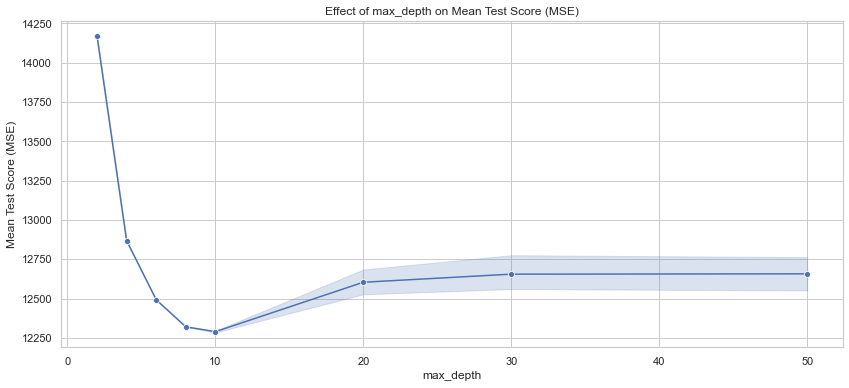

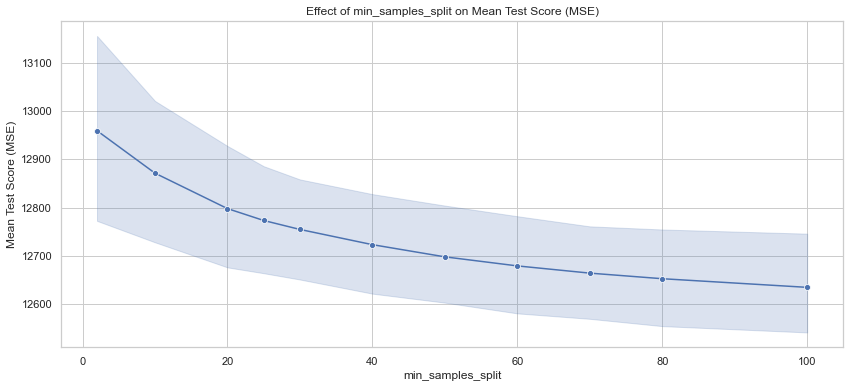

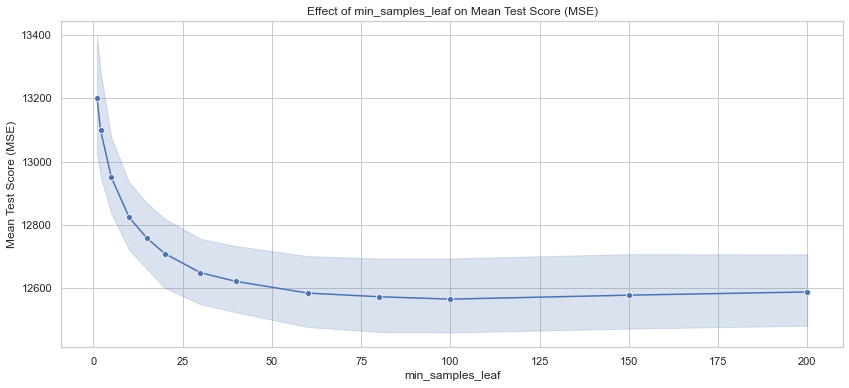

In [39]:
# Extract results from GridSearchCV
resultsdt = pd.DataFrame(grid_searchdt.cv_results_)

# Convert negative mean squared error to positive for easier interpretation
resultsdt['mean_test_score'] = -resultsdt['mean_test_score']

# Plotting results for different max_depth values
plt.figure(figsize=(14, 6))
sns.lineplot(data=resultsdt, x='param_max_depth', y='mean_test_score', marker='o')
plt.title('Effect of max_depth on Mean Test Score (MSE)')
plt.xlabel('max_depth')
plt.ylabel('Mean Test Score (MSE)')
plt.grid(True)
plt.show()

# Plotting results for different min_samples_split values
plt.figure(figsize=(14, 6))
sns.lineplot(data=resultsdt, x='param_min_samples_split', y='mean_test_score', marker='o')
plt.title('Effect of min_samples_split on Mean Test Score (MSE)')
plt.xlabel('min_samples_split')
plt.ylabel('Mean Test Score (MSE)')
plt.grid(True)
plt.show()

# Plotting results for different min_samples_leaf values
plt.figure(figsize=(14, 6))
sns.lineplot(data=resultsdt, x='param_min_samples_leaf', y='mean_test_score', marker='o')
plt.title('Effect of min_samples_leaf on Mean Test Score (MSE)')
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Test Score (MSE)')
plt.grid(True)
plt.show()


                Feature  Importance
2            model_year    0.646140
3                milage    0.207956
5        engine_encoded    0.120579
0         brand_encoded    0.011177
1         model_encoded    0.008944
6  transmission_encoded    0.003549
4     fuel_type_encoded    0.000849
7      accident_encoded    0.000434
8   clean_title_encoded    0.000372


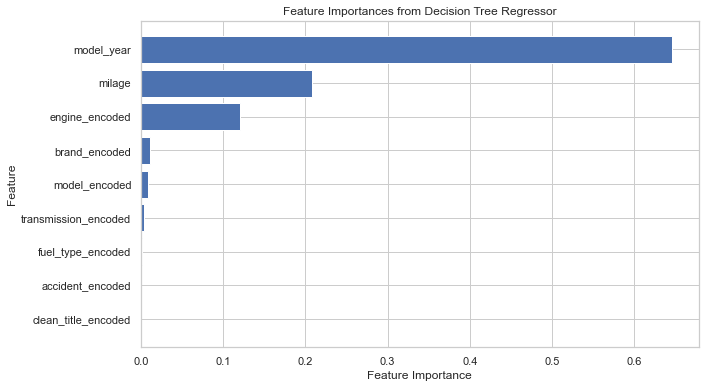

In [40]:
# Get feature importances from the best model
feature_importances = best_modeldt.feature_importances_

# Create a DataFrame to display feature names and their importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree Regressor')
plt.gca().invert_yaxis()
plt.show()

#### XGBoost

In [60]:
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Escalado Min-Max de las características
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Escalado Min-Max de la variable objetivo
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.fit_transform(y_test.values.reshape(-1, 1)).flatten()

# Función objetivo para Optuna
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }

    # Definir el modelo XGBoost
    model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        random_state=42, 
        early_stopping_rounds=50,  # Early stopping
        **param
    )

    # Entrenar el modelo con early stopping
    model.fit(
        X_train_scaled, y_train_scaled,
        eval_set=[(X_test_scaled, y_test_scaled)],
        verbose=False
    )

    # Predecir en el set de test
    y_pred_scaled = model.predict(X_test_scaled)

    # Invertir el escalado de las predicciones
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

    # Calcular el error cuadrático medio (MSE)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Crear un estudio de Optuna para optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
print(f"Best trial: {study.best_trial.params}")

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_trial.params
best_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42, 
    early_stopping_rounds=50, 
    **best_params
)

# Entrenar el modelo con los mejores hiperparámetros
best_model.fit(
    X_train_scaled, y_train_scaled,
    eval_set=[(X_test_scaled, y_test_scaled)],
    verbose=False
)

# Predecir en los sets de entrenamiento y test
y_train_pred_scaled = best_model.predict(X_train_scaled)
y_test_pred_scaled = best_model.predict(X_test_scaled)

# Invertir el escalado de las predicciones
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# Evaluar el modelo en el set de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluar el modelo en el set de test
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir resultados
print(f"Best Parameters: {study.best_trial.params}")
print(f"Training Set - Mean Squared Error: {mse_train}")
print(f"Training Set - R^2 Score: {r2_train}")
print(f"Test Set - Mean Squared Error: {mse_test}")
print(f"Test Set - R^2 Score: {r2_test}")


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7ff09a9f0a60>>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 599, in _next_wrapper
    def input_data(
  File "/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py", line 701, in throw_if
    sig = signature(func)
  File "/opt/anaconda3/lib/python3.9/inspect.py", line 3111, in signature
    return Signature.from_callable(obj, follow_wrapped=follow_wrapped)
  File "/opt/anaconda3/lib/python3.9/inspect.py", line 2860, in from_callable
    return _signature_from_callable(obj, sigcls=cls,
  File "/opt/anaconda3/lib/python3.9/inspect.py", line 2281, in _signature_from_callable
    sig = obj.__signature__
KeyboardInterrupt: 
[W 2024-09-23 21:00:41,178] Trial 9 failed with parameters: {'learning_rate': 0.0102830575505969, 'n_estimators': 6092, 'max_depth': 19, 'subsample': 0.7399251

XGBoostError: [21:00:41] /Users/runner/work/xgboost/xgboost/src/data/iterative_dmatrix.cc:262: Check failed: rbegin == Info().num_row_ (301654 vs. 150827) : 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000015557e355 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000155691905 xgboost::data::IterativeDMatrix::InitFromCPU(xgboost::Context const*, xgboost::BatchParam const&, void*, float, std::__1::shared_ptr<xgboost::DMatrix>) + 10933
  [bt] (2) 3   libxgboost.dylib                    0x000000015568e74c xgboost::data::IterativeDMatrix::IterativeDMatrix(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 1356
  [bt] (3) 4   libxgboost.dylib                    0x0000000155642f89 xgboost::DMatrix* xgboost::DMatrix::Create<void*, void*, void (void*), int (void*)>(void*, void*, std::__1::shared_ptr<xgboost::DMatrix>, void (*)(void*), int (*)(void*), float, int, int) + 121
  [bt] (4) 5   libxgboost.dylib                    0x000000015558944e XGQuantileDMatrixCreateFromCallback + 590
  [bt] (5) 6   libffi.7.dylib                      0x000000010db3dead ffi_call_unix64 + 85



In [44]:
# Escalado Standard de las características
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_train)

# Escalado Standard de la variable objetivo
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Función objetivo para Optuna con LightGBM y KFold
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'boosting_type': 'gbdt',  # Tipo de boosting por defecto
    }

    # Definir el modelo LightGBM
    model = lgb.LGBMRegressor(
        objective='regression', 
        random_state=42, 
        **param
    )

    # KFold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_list = []
    
    for train_index, test_index in kf.split(X_scaled):
        X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
        y_train_fold, y_test_fold = y_scaled[train_index], y_scaled[test_index]

        # Entrenar el modelo con el set de entrenamiento del fold
        model.fit(X_train_fold, y_train_fold)

        # Predecir en el set de test del fold
        y_pred_fold = model.predict(X_test_fold)

        # Calcular el error cuadrático medio (MSE) y agregarlo a la lista
        mse = mean_squared_error(y_test_fold, y_pred_fold)
        mse_list.append(mse)

    # Devolver el MSE promedio entre todos los folds
    return np.mean(mse_list)

# Crear un estudio de Optuna para optimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)

# Obtener los mejores hiperparámetros
print(f"Best trial: {study.best_trial.params}")

# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_trial.params
best_model = lgb.LGBMRegressor(
    objective='regression', 
    random_state=42, 
    **best_params
)

# Usar el conjunto completo de datos para entrenamiento y validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []
rmse_train_inv_list = []
rmse_test_inv_list = []

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_scaled[train_index], y_scaled[test_index]

    # Entrenar el modelo con los mejores hiperparámetros
    best_model.fit(X_train_fold, y_train_fold)

    # Predecir en los sets de entrenamiento y prueba
    y_train_pred_fold = best_model.predict(X_train_fold)
    y_test_pred_fold = best_model.predict(X_test_fold)

    # Calcular el MSE y R^2 en el set de entrenamiento
    mse_train = mean_squared_error(y_train_fold, y_train_pred_fold)
    r2_train = r2_score(y_train_fold, y_train_pred_fold)
    mse_train_list.append(mse_train)
    r2_train_list.append(r2_train)

    # Calcular el MSE y R^2 en el set de test
    mse_test = mean_squared_error(y_test_fold, y_test_pred_fold)
    r2_test = r2_score(y_test_fold, y_test_pred_fold)
    mse_test_list.append(mse_test)
    r2_test_list.append(r2_test)

    # Revertir el escalado de las predicciones y los valores reales
    y_train_fold_inv = scaler_y.inverse_transform(y_train_fold.reshape(-1, 1)).flatten()
    y_train_pred_fold_inv = scaler_y.inverse_transform(y_train_pred_fold.reshape(-1, 1)).flatten()
    y_test_fold_inv = scaler_y.inverse_transform(y_test_fold.reshape(-1, 1)).flatten()
    y_test_pred_fold_inv = scaler_y.inverse_transform(y_test_pred_fold.reshape(-1, 1)).flatten()

    # Calcular el RMSE con las predicciones escaladas de vuelta
    rmse_train_inv = np.sqrt(mean_squared_error(y_train_fold_inv, y_train_pred_fold_inv))
    rmse_test_inv = np.sqrt(mean_squared_error(y_test_fold_inv, y_test_pred_fold_inv))
    rmse_train_inv_list.append(rmse_train_inv)
    rmse_test_inv_list.append(rmse_test_inv)

# Calcular el RMSE promedio y R² en los sets de entrenamiento y test
rmse_train_avg = np.sqrt(np.mean(mse_train_list))
rmse_test_avg = np.sqrt(np.mean(mse_test_list))
r2_train_avg = np.mean(r2_train_list)
r2_test_avg = np.mean(r2_test_list)

# RMSE promedio en la escala original
rmse_train_inv_avg = np.mean(rmse_train_inv_list)
rmse_test_inv_avg = np.mean(rmse_test_inv_list)

# Imprimir resultados
print(f"Best Parameters: {study.best_trial.params}")
print(f"Training Set - Average RMSE (scaled): {rmse_train_avg}")
print(f"Training Set - Average R^2 Score: {r2_train_avg}")
print(f"Test Set - Average RMSE (scaled): {rmse_test_avg}")
print(f"Test Set - Average R^2 Score: {r2_test_avg}")
print(f"Training Set - Average RMSE (original scale): {rmse_train_inv_avg}")
print(f"Test Set - Average RMSE (original scale): {rmse_test_inv_avg}")


[I 2024-09-18 20:32:54,305] A new study created in memory with name: no-name-17b4b96a-9602-4dc2-8959-0e4d6fbf18d4


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 111322, number of used features: 11
[LightGBM] [Info] Start training from score -0.000330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-09-18 20:33:49,410] Trial 0 finished with value: 0.9991287051353808 and parameters: {'learning_rate': 0.0012769211888782636, 'n_estimators': 5832, 'max_depth': 3, 'num_leaves': 163, 'subsample': 0.9334952696747275, 'colsample_bytree': 0.9882079692916645, 'min_child_weight': 41, 'reg_alpha': 1.5781321868795968, 'reg_lambda': 1.191766649999405}. Best is trial 0 with value: 0.9991287051353808.


Best trial: {'learning_rate': 0.0012769211888782636, 'n_estimators': 5832, 'max_depth': 3, 'num_leaves': 163, 'subsample': 0.9334952696747275, 'colsample_bytree': 0.9882079692916645, 'min_child_weight': 41, 'reg_alpha': 1.5781321868795968, 'reg_lambda': 1.191766649999405}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 111322, number of used features: 11
[LightGBM] [Info] Start training from score -0.000330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

In [ ]:
# Entrenar el modelo final con los mejores hiperparámetros
best_params = study.best_trial.params
best_model = lgb.LGBMRegressor(
    objective='regression', 
    random_state=42, 
    **best_params
)

# Usar el conjunto completo de datos para entrenamiento y validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_train_list = []
mse_test_list = []
r2_train_list = []
r2_test_list = []

for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y_scaled[train_index], y_scaled[test_index]

    # Entrenar el modelo con los mejores hiperparámetros
    best_model.fit(X_train_fold, y_train_fold)

    # Predecir en los sets de entrenamiento y prueba
    y_train_pred_fold = best_model.predict(X_train_fold)
    y_test_pred_fold = best_model.predict(X_test_fold)

    # Calcular el MSE y R^2 en el set de entrenamiento
    mse_train = mean_squared_error(y_train_fold, y_train_pred_fold)
    r2_train = r2_score(y_train_fold, y_train_pred_fold)
    mse_train_list.append(mse_train)
    r2_train_list.append(r2_train)

    # Calcular el MSE y R^2 en el set de test
    mse_test = mean_squared_error(y_test_fold, y_test_pred_fold)
    r2_test = r2_score(y_test_fold, y_test_pred_fold)
    mse_test_list.append(mse_test)
    r2_test_list.append(r2_test)

# Calcular el RMSE promedio y R² en los sets de entrenamiento y test
rmse_train_avg = np.sqrt(np.mean(mse_train_list))
rmse_test_avg = np.sqrt(np.mean(mse_test_list))
r2_train_avg = np.mean(r2_train_list)
r2_test_avg = np.mean(r2_test_list)

# Imprimir resultados
print(f"Best Parameters: {study.best_trial.params}")
print(f"Training Set - Average RMSE: {rmse_train_avg}")
print(f"Training Set - Average R^2 Score: {r2_train_avg}")
print(f"Test Set - Average RMSE: {rmse_test_avg}")
print(f"Test Set - Average R^2 Score: {r2_test_avg}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 139153, number of used features: 11
[LightGBM] [Info] Start training from score 0.001620
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

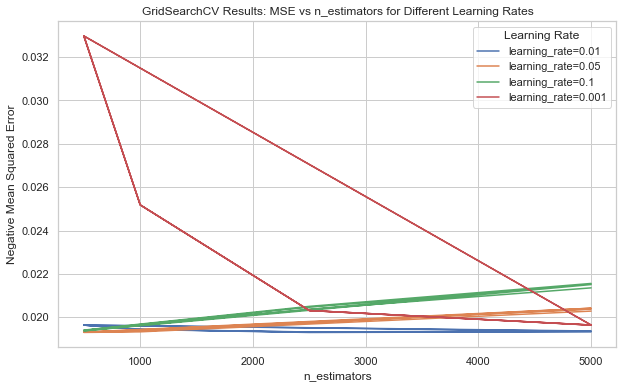

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertimos los resultados de GridSearchCV a un DataFrame
results = pd.DataFrame(grid_searchxgb.cv_results_)

# Gráfico del Mean Test Score (MSE) en función de los hiperparámetros
plt.figure(figsize=(10, 6))

# Graficamos las puntuaciones medias del test en función de los n_estimators
for lr in param_grid['learning_rate']:
    subset = results[results['param_learning_rate'] == lr]
    plt.plot(subset['param_n_estimators'], -subset['mean_test_score'], label=f'learning_rate={lr}')

plt.xlabel('n_estimators')
plt.ylabel('Negative Mean Squared Error')
plt.title('GridSearchCV Results: MSE vs n_estimators for Different Learning Rates')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()


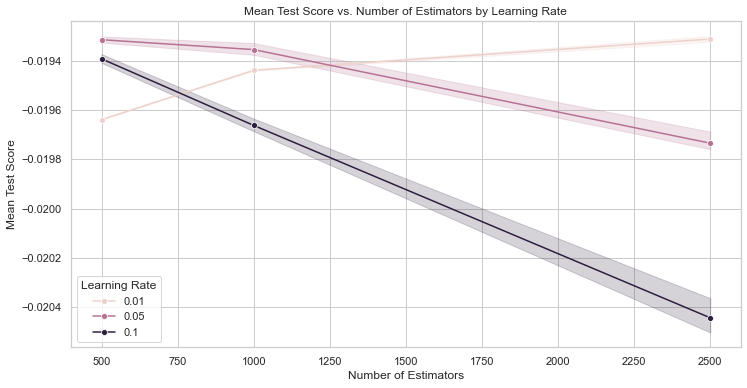

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the cross-validation results
cv_results = grid_searchxgb.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'mean_test_score': cv_results['mean_test_score'],
    'std_test_score': cv_results['std_test_score'],
    'params': cv_results['params']
})

# Extract hyperparameters from the params column for plotting
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df, params_df], axis=1)

# Set up the plot for Learning Rate
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='n_estimators', y='mean_test_score', hue='learning_rate', marker='o')
plt.title('Mean Test Score vs. Number of Estimators by Learning Rate')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Asumiendo que train_df ya está definido y preprocesado
# Features y variable objetivo
X = train_df[['brand_encoded', 'model_encoded', 'model_year', 'milage',
              'fuel_type_encoded', 'engine_encoded', 'transmission_encoded',
              'ext_col_encoded', 'int_col_encoded', 'accident_encoded', 'clean_title_encoded']]
y = train_df['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir el modelo XGBoost con los mejores parámetros
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    eval_metric='rmse', 
    random_state=42
)

# Definir la cuadrícula de parámetros para GridSearchCV
param_grid = {
    'lambda': [0.03880258557285165],
    'alpha': [0.02129832295514386],
    'colsample_bytree': [0.4],
    'subsample': [0.7],
    'learning_rate': [0.014],
    'max_depth': [17],
    'random_state': [2020],
    'min_child_weight': [85],
    'n_estimators': [10000]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimizar MSE
    verbose=1,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Obtener el mejor estimador
best_model = grid_search.best_estimator_

# Predecir en los conjuntos de entrenamiento y prueba
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluar el modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluar el modelo en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir resultados
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Set - Mean Squared Error: {mse_train}")
print(f"Training Set - R^2 Score: {r2_train}")
print(f"Test Set - Mean Squared Error: {mse_test}")
print(f"Test Set - R^2 Score: {r2_test}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits


KeyboardInterrupt: 

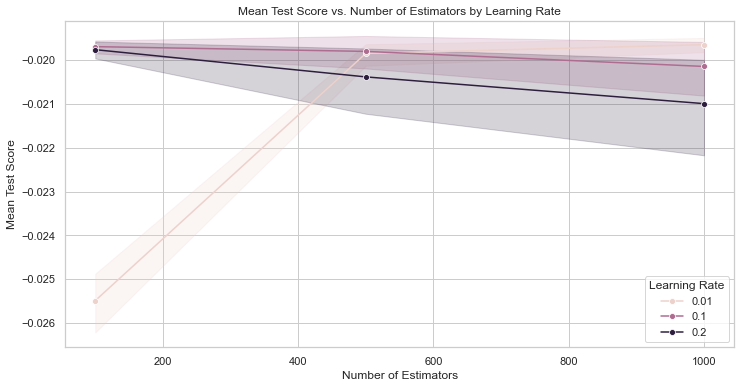

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get the cross-validation results
cv_results = grid_search.cv_results_

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'mean_test_score': cv_results['mean_test_score'],
    'std_test_score': cv_results['std_test_score'],
    'params': cv_results['params']
})

# Extract hyperparameters from the params column for plotting
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df, params_df], axis=1)

# Set up the plot for Learning Rate
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='n_estimators', y='mean_test_score', hue='learning_rate', marker='o')
plt.title('Mean Test Score vs. Number of Estimators by Learning Rate')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()


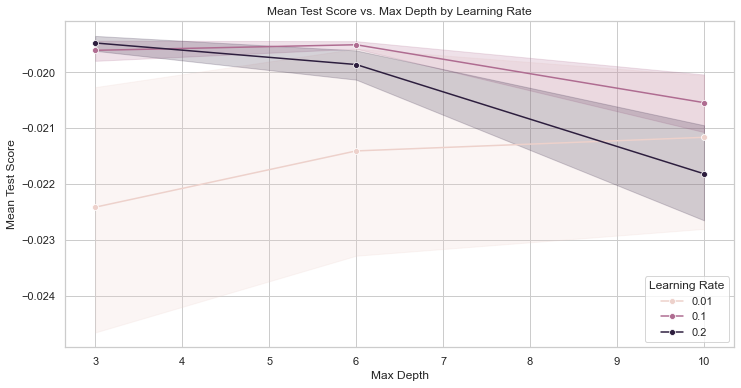

In [38]:
# Set up the plot for Max Depth
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='max_depth', y='mean_test_score', hue='learning_rate', marker='o')
plt.title('Mean Test Score vs. Max Depth by Learning Rate')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()


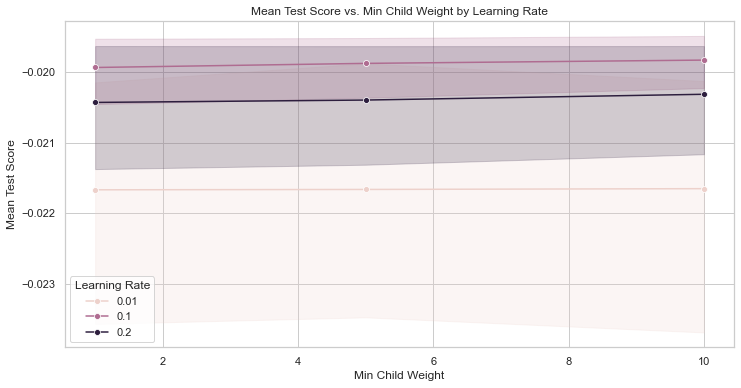

In [39]:
# Set up the plot for Min Child Weight
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='min_child_weight', y='mean_test_score', hue='learning_rate', marker='o')
plt.title('Mean Test Score vs. Min Child Weight by Learning Rate')
plt.xlabel('Min Child Weight')
plt.ylabel('Mean Test Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()


/var/folders/6q/q2z5qc4s3ldfxkxmcbk5sqj00000gn/T/ipykernel_22650/641605039.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Learning Rate')


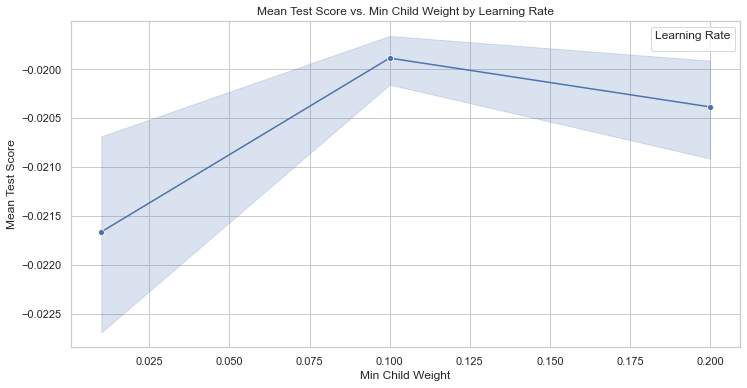

In [40]:
# Set up the plot for Min Child Weight
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='learning_rate', y='mean_test_score', marker='o')
plt.title('Mean Test Score vs. Min Child Weight by Learning Rate')
plt.xlabel('Min Child Weight')
plt.ylabel('Mean Test Score')
plt.legend(title='Learning Rate')
plt.grid(True)
plt.show()

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# Min-Max scaling of the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Min-Max scaling of the target variable
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Define the LightGBM regressor with predetermined hyperparameters
model = LGBMRegressor(
    learning_rate=0.05,  # Predetermined learning rate
    num_leaves=31,       # Predetermined number of leaves
    max_depth=-1,        # No limit on tree depth
    n_estimators=2000,   # Predetermined number of boosting iterations
    subsample=0.8,       # Fraction of data used for fitting each iteration
    colsample_bytree=0.8,  # Fraction of features used for fitting each iteration
    reg_alpha=0.1,       # L1 regularization term on weights
    reg_lambda=0.1,      # L2 regularization term on weights
    random_state=42
)

# Fit the model
model.fit(X_train_scaled, y_train_scaled)

# Predict on the training and test sets
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the scaled predictions to the original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Training Set - Mean Squared Error: {mse_train}")
print(f"Training Set - R^2 Score: {r2_train}")
print(f"Test Set - Mean Squared Error: {mse_test}")
print(f"Test Set - R^2 Score: {r2_test}")


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 139153, number of used features: 9
[LightGBM] [Info] Start training from score 0.352704
Training Set - Mean Squared Error: 117099494.3363282
Training Set - R^2 Score: 0.700185536929619
Test Set - Mean Squared Error: 135401282.55264634
Test Set - R^2 Score: 0.6475212775761396


In [33]:
from lightgbm import LGBMRegressor

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# Assuming train_df is already defined and preprocessed
# Features and target variable
X = train_df[['brand_encoded', 'model_encoded', 'model_year', 'milage',
              'fuel_type_encoded', 'engine_encoded', 'transmission_encoded',
              'ext_col_encoded', 'int_col_encoded', 'accident_encoded', 'clean_title_encoded']]
y = train_df['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Min-Max scaling of the features
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Min-Max scaling of the target variable
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Define the LightGBM regressor
model = LGBMRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    #'max_depth': [-1, 10, 20],
    'n_estimators': [1000, 2500 ,5000, 10000]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the model
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best estimator
best_model = grid_search.best_estimator_

# Predict on the training and test sets
y_train_pred_scaled = best_model.predict(X_train_scaled)
y_test_pred_scaled = best_model.predict(X_test_scaled)

# Inverse transform the scaled predictions to the original scale
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# Evaluate the model on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Set - Mean Squared Error: {mse_train}")
print(f"Training Set - R^2 Score: {r2_train}")
print(f"Test Set - Mean Squared Error: {mse_test}")
print(f"Test Set - R^2 Score: {r2_test}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-

KeyboardInterrupt: 

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the Random Forest Regressor
model = RandomForestRegressor(random_state=42)

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300, 500, 1000],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [5, 10, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [4, 6, 8, 10, 15],    # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

# Initialize GridSearchCV with the Random Forest Regressor and parameter grid
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Evaluate the best model on the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the best model on the test set
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Training Set - Mean Squared Error: {mse_train}")
print(f"Training Set - R^2 Score: {r2_train}")
print(f"Test Set - Mean Squared Error: {mse_test}")
print(f"Test Set - R^2 Score: {r2_test}")


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

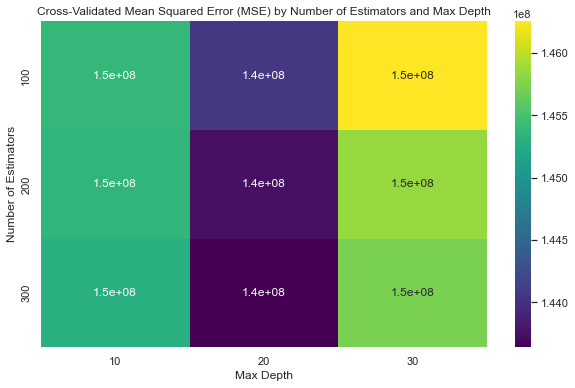

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Convert negative MSE to positive for better interpretability
results['mean_test_score'] = -results['mean_test_score']

# Pivot the data to visualize it as a heatmap
pivot_table = results.pivot_table(
    values='mean_test_score', 
    index='param_n_estimators', 
    columns='param_max_depth'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Cross-Validated Mean Squared Error (MSE) by Number of Estimators and Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.show()


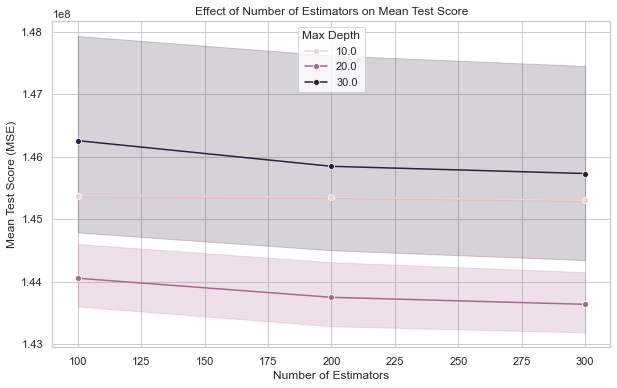

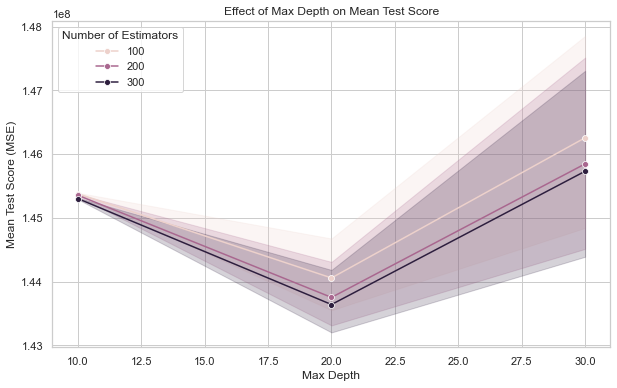

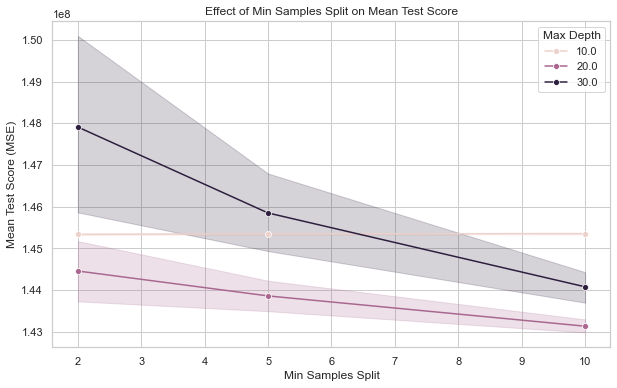

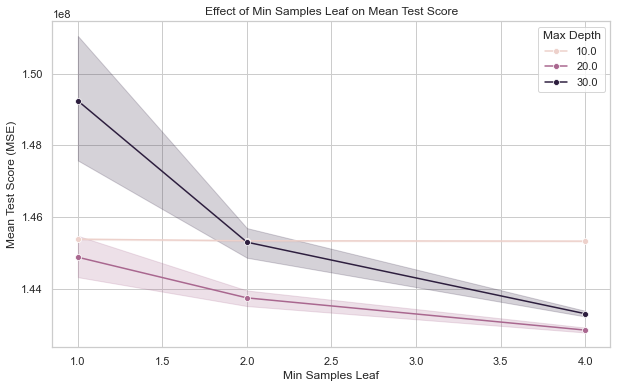

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Convert negative MSE to positive for better interpretability
results['mean_test_score'] = -results['mean_test_score']

# Plotting the effect of 'n_estimators' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', marker='o')
plt.title('Effect of Number of Estimators on Mean Test Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

# Plotting the effect of 'max_depth' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_max_depth', y='mean_test_score', hue='param_n_estimators', marker='o')
plt.title('Effect of Max Depth on Mean Test Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Number of Estimators')
plt.grid(True)
plt.show()

# Plotting the effect of 'min_samples_split' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_score', hue='param_max_depth', marker='o')
plt.title('Effect of Min Samples Split on Mean Test Score')
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

# Plotting the effect of 'min_samples_leaf' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_score', hue='param_max_depth', marker='o')
plt.title('Effect of Min Samples Leaf on Mean Test Score')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()


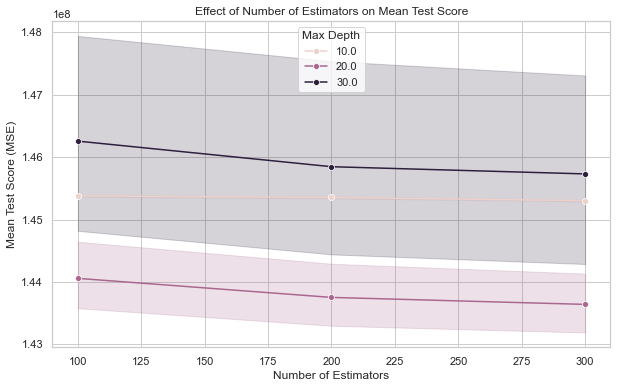

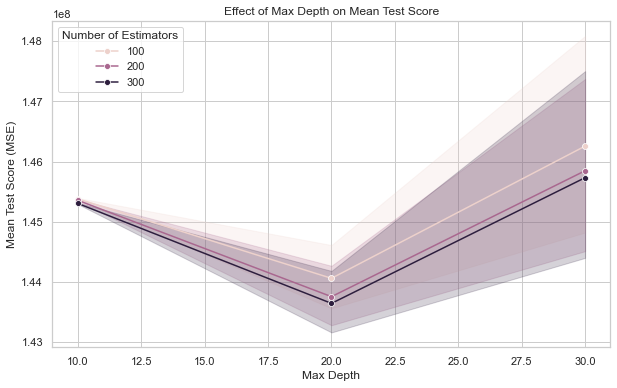

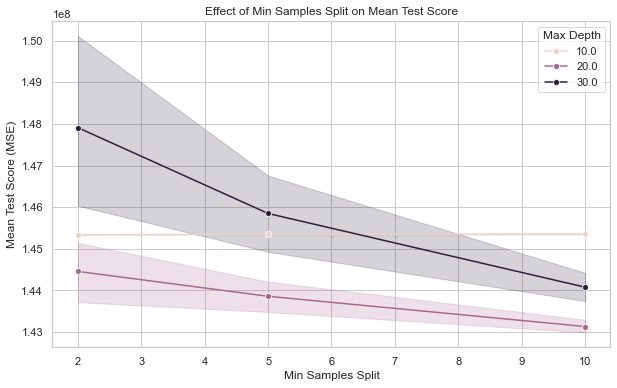

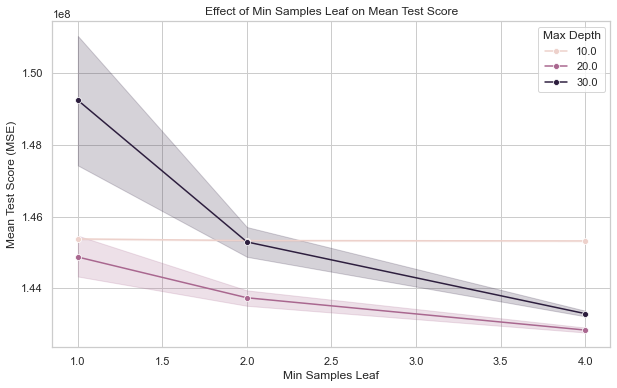

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Convert negative MSE to positive for better interpretability
results['mean_test_score'] = -results['mean_test_score']

# Plotting the effect of 'n_estimators' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', hue='param_max_depth', marker='o')
plt.title('Effect of Number of Estimators on Mean Test Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

# Plotting the effect of 'max_depth' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_max_depth', y='mean_test_score', hue='param_n_estimators', marker='o')
plt.title('Effect of Max Depth on Mean Test Score')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Number of Estimators')
plt.grid(True)
plt.show()

# Plotting the effect of 'min_samples_split' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_min_samples_split', y='mean_test_score', hue='param_max_depth', marker='o')
plt.title('Effect of Min Samples Split on Mean Test Score')
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()

# Plotting the effect of 'min_samples_leaf' on the model performance
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_min_samples_leaf', y='mean_test_score', hue='param_max_depth', marker='o')
plt.title('Effect of Min Samples Leaf on Mean Test Score')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Mean Test Score (MSE)')
plt.legend(title='Max Depth')
plt.grid(True)
plt.show()


In [47]:
pip install --upgrade numpy catboost

  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 2.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 11.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: catboost
    Found existing installation: catboost 1.2.5
    Uninstalling catboost-1.2.5:
      Successfully uninstalled catboost-1.2.5
ERROR: Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 105, in _run_wrapper
    status = _inner_run()
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/base_command.py", line 96, in _inner_run
    return self.run(options, args)
  File "/opt/anaconda3/lib/python3.9/site-packages/pip/_internal/cli/req_command.py", line 67, in wra

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

# Escalado Min-Max de las características
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Escalado Min-Max de la variable objetivo
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Definir el modelo CatBoostRegressor
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',  # Usar RMSE directamente
    random_seed=42,
    verbose=1 # Imprime el progreso cada 100 iteraciones
)

# Ajustar el modelo
model.fit(X_train_scaled, y_train_scaled)

# Predecir en los conjuntos de entrenamiento y prueba
y_train_pred_scaled = model.predict(X_train_scaled)
y_test_pred_scaled = model.predict(X_test_scaled)

# Inversión de la transformación para las predicciones
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# Evaluar el modelo en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

# Evaluar el modelo en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir resultados
print(f"Training Set - Mean Squared Error: {mse_train}")
print(f"Training Set - RMSE: {rmse_train}")
print(f"Training Set - R^2 Score: {r2_train}")
print(f"Test Set - Mean Squared Error: {mse_test}")
print(f"Test Set - RMSE: {rmse_test}")
print(f"Test Set - R^2 Score: {r2_test}")


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [49]:
# Features and target variable
test_df = test_df[['brand_encoded', 'model_encoded', 'model_year', 'milage' ,'fuel_type_encoded', 
              'engine_encoded', 'transmission_encoded', 'ext_col_encoded', 'int_col_encoded', 
              'accident_encoded', 'clean_title_encoded']]

In [62]:
# Min-Max scaling of the features
scaler_X = MinMaxScaler()
test_scaled = scaler_X.fit_transform(test_df)
test_scaled = scaler_X.transform(test_df)

# Predict on the training and test sets
y_test_pred_scaled = best_model.predict(test_scaled)

# Inverse transform the scaled predictions to the original scale
y_subm_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))


In [63]:
test_df = pd.read_csv('test.csv')  

In [64]:
# If you want to add the predictions to the DataFrame
test_df['price'] = y_subm_pred

In [65]:
test_df = test_df[['id', 'price']]

In [66]:
test_df

,id,price
0,188533,18199.013855
1,188534,50471.537947
2,188535,51523.813585
3,188536,22128.496776
4,188537,30594.486392
...,...,...
125685,314218,25083.747827
125686,314219,41146.192287
125687,314220,17717.497441
125688,314221,13828.119921


In [67]:
# Export to CSV with index as a column
test_df.to_csv('test_df_with_predictions.csv', index=False)